# Predicting Loans

In this project, we will work with financial lending data from [Lending Club](https://www.lendingclub.com/) - a marketplace for personal loans that matches borrowers who are seeking a loan with investors looking to lend money and make a return. We will work with a dataset containing approved loans data from 2007 to 2011, since a good number of the loans have already finished. In the datasets for later years, many of the loans are current and still being paid off. Our goal is to build a machine learning model that can accurately predict if a borrower will pay off their loan on time or not.

Description of each column is available in the data dictionary stored on [Google Drive](https://docs.google.com/spreadsheets/d/191B2yJ4H1ZPXq0_ByhUgWMFZOYem5jFz0Y3by_7YBY4/edit#gid=2081333097). The **LoanStats** sheet describes the approved loans datasets and the **RejectStats** describes the rejected loans datasets. We will focus on the approved loans only as they are available to investors. Since we are interested whether a loan will be paid on time or not, we will work only with the **LoanStats** sheet.

For learning purposes the size of the dataset has been reduced. Also some columns have been removed - `desc`, `url`, all columns with over 50% missing values.

Let's tart by reading in the data.

In [68]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict
from sklearn.ensemble import RandomForestClassifier

In [69]:
loans_2007 = pd.read_csv('loans_2007.csv', low_memory=False)
loans_2007.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,last_pymnt_amnt,last_credit_pull_d,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,chargeoff_within_12_mths,delinq_amnt,pub_rec_bankruptcies,tax_liens
0,1077501,1296599.0,5000.0,5000.0,4975.0,36 months,10.65%,162.87,B,B2,...,171.62,Jun-2016,0.0,1.0,INDIVIDUAL,0.0,0.0,0.0,0.0,0.0
1,1077430,1314167.0,2500.0,2500.0,2500.0,60 months,15.27%,59.83,C,C4,...,119.66,Sep-2013,0.0,1.0,INDIVIDUAL,0.0,0.0,0.0,0.0,0.0
2,1077175,1313524.0,2400.0,2400.0,2400.0,36 months,15.96%,84.33,C,C5,...,649.91,Jun-2016,0.0,1.0,INDIVIDUAL,0.0,0.0,0.0,0.0,0.0
3,1076863,1277178.0,10000.0,10000.0,10000.0,36 months,13.49%,339.31,C,C1,...,357.48,Apr-2016,0.0,1.0,INDIVIDUAL,0.0,0.0,0.0,0.0,0.0
4,1075358,1311748.0,3000.0,3000.0,3000.0,60 months,12.69%,67.79,B,B5,...,67.79,Jun-2016,0.0,1.0,INDIVIDUAL,0.0,0.0,0.0,0.0,0.0


In [70]:
print('Original number of rows: {} and columns: {}:'.format(loans_2007.shape[0], loans_2007.shape[1]))

Original number of rows: 42538 and columns: 52:


## Clean up

There are too many columns to work with. Let's split them in groups and see which ones we will keep and which ones are useful for our model. We need to make sure to remove columns with data leakage, i.e. columns which give us insight whether a loan is in the process of being or has been paid. 

We also need to choose a target column - the column which our model will predict.

In [71]:
cols= ['id','member_id','funded_amnt','funded_amnt_inv','grade','sub_grade','emp_title','issue_d']

loans_2007 = loans_2007.drop(cols, axis=1)

In [72]:
loans_2007 = loans_2007.drop(['out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'zip_code'], axis=1)

In [73]:
loans_2007 = loans_2007.drop(['total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_d',
'last_pymnt_amnt'], axis=1)

In [74]:
loans_2007.head()

,loan_amnt,term,int_rate,installment,emp_length,home_ownership,annual_inc,verification_status,loan_status,pymnt_plan,...,initial_list_status,last_credit_pull_d,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,chargeoff_within_12_mths,delinq_amnt,pub_rec_bankruptcies,tax_liens
0,5000.0,36 months,10.65%,162.87,10+ years,RENT,24000.0,Verified,Fully Paid,n,...,f,Jun-2016,0.0,1.0,INDIVIDUAL,0.0,0.0,0.0,0.0,0.0
1,2500.0,60 months,15.27%,59.83,< 1 year,RENT,30000.0,Source Verified,Charged Off,n,...,f,Sep-2013,0.0,1.0,INDIVIDUAL,0.0,0.0,0.0,0.0,0.0
2,2400.0,36 months,15.96%,84.33,10+ years,RENT,12252.0,Not Verified,Fully Paid,n,...,f,Jun-2016,0.0,1.0,INDIVIDUAL,0.0,0.0,0.0,0.0,0.0
3,10000.0,36 months,13.49%,339.31,10+ years,RENT,49200.0,Source Verified,Fully Paid,n,...,f,Apr-2016,0.0,1.0,INDIVIDUAL,0.0,0.0,0.0,0.0,0.0
4,3000.0,60 months,12.69%,67.79,1 year,RENT,80000.0,Source Verified,Current,n,...,f,Jun-2016,0.0,1.0,INDIVIDUAL,0.0,0.0,0.0,0.0,0.0


In [75]:
print('Number of columns after clean up:', loans_2007.shape[1])

Number of columns after clean up: 32


## Choosing the Target column

Our target column is `loan status`. Explanation of the different statuses a loan can have can be fould on [Lending Club's website](https://help.lendingclub.com/hc/en-us/articles/215488038-What-do-the-different-Note-statuses-mean-).

The two statuses that are of interest to us are:
- `Fully Paid` - Loan has been fully repaid, either at the expiration of the 3- or 5-year year term or as a result of a prepayment.
- `Charged Off` - Loan for which there is no longer a reasonable expectation of further payments.

In the next few cells we will:

- see the value counts for each loan status;
- keep only rows with `Fully Paid` or `Charged Off` status;
- replace `Fully Paid` with `1` and `Charged Off` with `0` since we need our data to be in numeric format in order for the machine learning models to be able to work with it.

In [76]:
loans_2007['loan_status'].value_counts().sort_values(ascending=False)

Fully Paid                                             33136
Charged Off                                             5634
Does not meet the credit policy. Status:Fully Paid      1988
Current                                                  961
Does not meet the credit policy. Status:Charged Off      761
Late (31-120 days)                                        24
In Grace Period                                           20
Late (16-30 days)                                          8
Default                                                    3
Name: loan_status, dtype: int64

In [77]:
map_dict = {
    'Fully Paid': 1,
    'Charged Off': 0
    
}

loans_2007['loan_status'] = loans_2007['loan_status'].replace(map_dict)

In [78]:
loans_2007 = loans_2007[(loans_2007['loan_status'] == 1) | (loans_2007['loan_status'] == 0)]

We also see that the `Fully Paid` loans are six times more than the `Charged Off` ones. We need to consider this when building our model as it might result in bias.

## Removing Single Value Colums

Now, let's see if there are any columns which hold only one value. If there are such, we will remove them from the dataset since they do not give information which changes depending on the status of the loan.

In [79]:
cols_to_drop = []

for col in loans_2007.columns:
    if len(loans_2007[col].dropna().unique()) == 1:
        cols_to_drop.append(col)

In [80]:
print('Columns to be removed:', cols_to_drop)

Columns to be removed: ['pymnt_plan', 'initial_list_status', 'collections_12_mths_ex_med', 'policy_code', 'application_type', 'acc_now_delinq', 'chargeoff_within_12_mths', 'delinq_amnt', 'tax_liens']


In [81]:
loans_2007 = loans_2007.drop(cols_to_drop, axis=1)

print('Columns after additional clean up:', loans_2007.shape[1])

Columns after additional clean up: 23


## Handling Missing Values

Now, let's see whether we have any columns with missing values. We see that there are three columns with 50 rows with missing values. Those rows will be dropped.

Employment length (`emp_length`) is important when deciding whether to grant a loan or not. We will keep the column despite the large number of missing values.

In [82]:
null_counts = loans_2007.isnull().sum()

null_counts

loan_amnt                  0
term                       0
int_rate                   0
installment                0
emp_length              1036
home_ownership             0
annual_inc                 0
verification_status        0
loan_status                0
purpose                    0
title                     11
addr_state                 0
dti                        0
delinq_2yrs                0
earliest_cr_line           0
inq_last_6mths             0
open_acc                   0
pub_rec                    0
revol_bal                  0
revol_util                50
total_acc                  0
last_credit_pull_d         2
pub_rec_bankruptcies     697
dtype: int64

In [83]:
loans_2007['pub_rec_bankruptcies'].value_counts(normalize=True, dropna=False)*100

0.0    93.943771
1.0     4.245551
NaN     1.797782
2.0     0.012897
Name: pub_rec_bankruptcies, dtype: float64

As we see above, the `pub_rec_bankruptcies` has very little variability. Let's drop the column.

In [84]:
loans_2007 = loans_2007.drop('pub_rec_bankruptcies', axis=1)

In [85]:
loans_2007 = loans_2007.dropna()

In [86]:
loans_2007.dtypes.value_counts()

object     12
float64    10
dtype: int64

In [87]:
print('Number of rows: {} and columns: {} after clean up.'.format(loans_2007.shape[0], loans_2007.shape[1]))

Number of rows: 37675 and columns: 22 after clean up.


## Text Columns

Now, let's focus on columns which hold data in `object` format.

- Some of the columns seem like they represent categorical values, but we should confirm by checking the number of unique values in those columns - `home_ownership`, `verification_status`, `purpose`, `term`, `title`, `purpose`. The last two seem to hold similar data.

- There are also some columns that represent numeric values, that need to be converted - `int_rate`, `revol_util`, `emp_length`.

- There are columns which hold date values - `earliest_cr_line`, `last_credit_pull_d`.

In [88]:
object_cols = loans_2007.select_dtypes(include=['object'])

object_cols.head()

,term,int_rate,emp_length,home_ownership,verification_status,loan_status,purpose,title,addr_state,earliest_cr_line,revol_util,last_credit_pull_d
0,36 months,10.65%,10+ years,RENT,Verified,1,credit_card,Computer,AZ,Jan-1985,83.7%,Jun-2016
1,60 months,15.27%,< 1 year,RENT,Source Verified,0,car,bike,GA,Apr-1999,9.4%,Sep-2013
2,36 months,15.96%,10+ years,RENT,Not Verified,1,small_business,real estate business,IL,Nov-2001,98.5%,Jun-2016
3,36 months,13.49%,10+ years,RENT,Source Verified,1,other,personel,CA,Feb-1996,21%,Apr-2016
5,36 months,7.90%,3 years,RENT,Source Verified,1,wedding,My wedding loan I promise to pay back,AZ,Nov-2004,28.3%,Jan-2016


In [89]:
cols = ['home_ownership', 'verification_status', 'emp_length', 'term', 'addr_state']

for c in cols:
    print(loans_2007[c].value_counts())
    print('-'*20)

RENT        18112
MORTGAGE    16686
OWN          2778
OTHER          96
NONE            3
Name: home_ownership, dtype: int64
--------------------
Not Verified       16281
Verified           11856
Source Verified     9538
Name: verification_status, dtype: int64
--------------------
10+ years    8545
< 1 year     4513
2 years      4303
3 years      4022
4 years      3353
5 years      3202
1 year       3176
6 years      2177
7 years      1714
8 years      1442
9 years      1228
Name: emp_length, dtype: int64
--------------------
 36 months    28234
 60 months     9441
Name: term, dtype: int64
--------------------
CA    6776
NY    3614
FL    2704
TX    2613
NJ    1776
IL    1447
PA    1442
VA    1347
GA    1323
MA    1272
OH    1149
MD    1008
AZ     807
WA     788
CO     748
NC     729
CT     711
MI     678
MO     648
MN     581
NV     466
SC     454
WI     427
OR     422
AL     420
LA     420
KY     311
OK     285
KS     249
UT     249
AR     229
DC     209
RI     194
NM     180
WV     1

In [90]:
print(loans_2007['title'].value_counts())
print('-'*20)
print(loans_2007['purpose'].value_counts())

Debt Consolidation                     2068
Debt Consolidation Loan                1599
Personal Loan                           624
Consolidation                           488
debt consolidation                      466
                                       ... 
IT Mgr Needs to Reduce Debt Balance       1
Deluccia Viola                            1
consoladation                             1
Have to buy furnace!                      1
for my car                                1
Name: title, Length: 18881, dtype: int64
--------------------
debt_consolidation    17751
credit_card            4911
other                  3711
home_improvement       2808
major_purchase         2083
small_business         1719
car                    1459
wedding                 916
medical                 655
moving                  552
house                   356
vacation                348
educational             312
renewable_energy         94
Name: purpose, dtype: int64


In [91]:
loans_2007 = loans_2007.drop(['last_credit_pull_d', 'addr_state', 'title', 'earliest_cr_line'], axis=1)

In [92]:
for c in ['int_rate', 'revol_util']:
    loans_2007[c] = loans_2007[c].str.rstrip('%').astype('float')

In [93]:
emp_dict = {
    '10+ years': 10,
    '< 1 year': 0,
    '2 years': 2,
    '3 years': 3,
    '4 years': 4,
    '5 years' : 5,
    '1 year': 1,
    '6 years': 6,
    '7 years': 7,
    '8 years': 8,
    '9 years' : 9,
    np.nan: 0,
    'n/a': 0
}

loans_2007['emp_length'] = loans_2007['emp_length'].replace(emp_dict)

In [94]:
cat_cols = ['home_ownership', 'verification_status', 'purpose', 'term']

dummy_cols = pd.get_dummies(loans_2007[cat_cols])
loans_2007 = pd.concat([loans_2007, dummy_cols], axis=1)
loans_2007 = loans_2007.drop(cat_cols, axis=1)

print('Final number of rows: {} and columns: {}.'.format(loans_2007.shape[0], loans_2007.shape[1]))

Final number of rows: 37675 and columns: 38.


## Error Metric

Before we make any predictions, we need to choose an error metric. The error metric will help us determine how accurate our predicitons are. Our goal is to accurately predict if a borrower will pay off their loan or not. We want to fund as many loans that will be paid off as possible to compensate for any potential losses from loans that are not paid off. This means we are concerned with false positives and false negative predictions. Our goal is to avoid false positives as much as possible.

There is a significant class imbalance in the `loan_status` column. There are 6 times as many loans that were paid off on time (`1`), than loans that were not (`0`). This causes a major issue when we use accuracy as a metric. We aim to achieve:

- high True Positive Rate (TPR)
- low False Positive Rate (FPR)

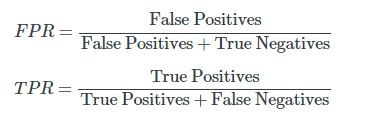

Let's now write a function which will calculate the TPR and FPR.

In [95]:
def positives(predictions, column):

    fp_filter = (predictions == 1) & (column == 0)
    fp = len(predictions[fp_filter])

    tp_filter = (predictions == 1) & (column == 1)
    tp = len(predictions[tp_filter])

    tn_filter = (predictions == 0) & (column == 0)
    tn = len(predictions[tn_filter])

    fn_filter = (predictions == 0) & (column == 1)
    fn = len(predictions[fn_filter])

    fpr = (fp/(fp+tn))*100
    tpr = (tp/(tp+fn))*100
    
    print('False Positive Rate: {:.2f}%.\nTrue Positive Rate: {:.2f}%.'.format(fpr, tpr))

## Logistic Regression

We are now ready to start making predictions. A good first model would be Logistic Regression.

In [96]:
features = loans_2007.drop('loan_status', axis=1)
target = loans_2007['loan_status'].astype('int')

In [97]:
lr = LogisticRegression(max_iter=400)
lr.fit(features, target)
predicitons = lr.predict(features)

positives(predicitons, target)

False Positive Rate: 99.68%.
True Positive Rate: 99.87%.


## Cross validation

Since we used one and the same data to train and test the model, our model was overfit. In order to get more realistic predictions, let's preform **K-fold cross validation**.

In [98]:
lr = LogisticRegression(max_iter=400)
predictions = cross_val_predict(lr, features, target, cv=3)

positives(predictions, target)

False Positive Rate: 99.55%.
True Positive Rate: 99.86%.


## Penalizing the classifier

Unfortunately, the model still does not account for the inbalance in the dataset. To account for that, we can have the model penalize the misclassificaiton of the less prevalent class. We can do this by setting the `class_weight` parameter to balanced when creating the `LogisticRegression` instance.

In [99]:
lr = LogisticRegression(max_iter=400, class_weight='balanced')
predictions = cross_val_predict(lr, features, target)

positives(predictions, target)

False Positive Rate: 33.68%.
True Positive Rate: 54.04%.


The FPR was significantly improved.

## Manual penalties

We can try to lower the false positive rate further by assigning a harsher penalty for misclassifying the negative class. To do this, we need to pass in a dictionary of penalty values to the `class_weight` parameter. Let's create a dictionary which will impose a penalty of `10` for misclassifying a `0`, and a penalty of `1` for misclassifying a `1`.

In [100]:
penalty = {
    0: 10,
    1: 1
}

lr = LogisticRegression(max_iter=400, class_weight=penalty)
predictions = cross_val_predict(lr, features, target)

positives(predictions, target)

False Positive Rate: 9.98%.
True Positive Rate: 19.92%.


It looks like assigning manual penalties lowered the false positive rate to 10% and thus lowered our risk. Howeverm this comes at the expense of True positives.
 
## Random Forest Classifier

Let's now try a more complex algorithm.

In [101]:
rf = RandomForestClassifier(random_state=1, class_weight='balanced')
predictions = cross_val_predict(rf, features, target)

positives(predictions, target)

False Positive Rate: 99.28%.
True Positive Rate: 99.86%.


Unfortunately, Random Forest Classifier did not improve our False Positive Rate. We could fix that by applying harsher penalties for misclasification of `0`.

## Next steps

- We can tweak the penalties further.
- We can try models other than a random forest and logistic regression.
- We can use some of the columns we discarded to generate better features.
- We can ensemble multiple models to get more accurate predictions.
- We can tune the parameters of the algorithm to achieve higher performance.